In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
#torch.cuda.set_device(0)

## Plotting

In [3]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [4]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [5]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [6]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [7]:
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

In [8]:
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [9]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [10]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

## Data Prep - Pascal

The most awful part

In [11]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/PASCAL_VOC'),
 PosixPath('data/pascal/pascal_val2012.json')]

In [12]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [13]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [14]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'
cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [15]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005867.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007772.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006240.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/000207.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006243.jpg')]

In [16]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [17]:
i = 0
# get im filename
im_dict = trn_j[IMAGES][i]
im_dict[FILE_NAME],im_dict[ID]
# open image
im = open_image(IMG_PATH/im_dict[FILE_NAME])
# get annotations
im_anno = trn_anno[im_dict[ID]]

In [18]:
# im_anno: a single list which has tuple (bb, )
im_anno[0]

(array([ 96, 155, 269, 350]), 7)

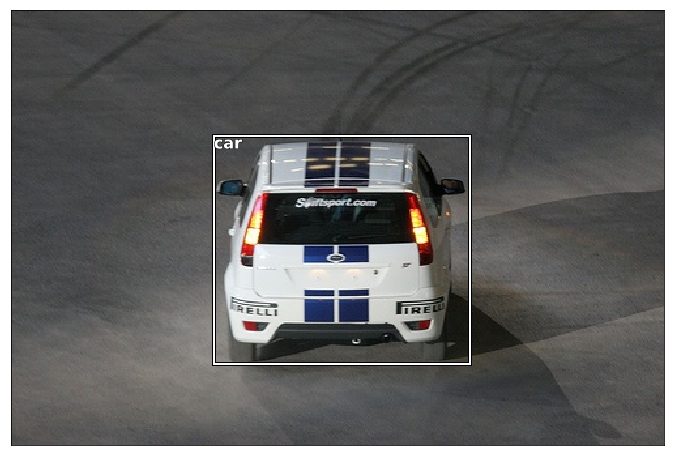

In [19]:
draw_im(im, im_anno)

In [20]:
# create multiclass classification csv
MC_CSV = PATH/'tmp/mc.csv'

mc = [set([cats[p[1]] for p in trn_anno[o]]) for o in trn_ids]
mcs = [' '.join(str(p) for p in o) for o in mc]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'clas': mcs}, columns=['fn','clas'])
df.to_csv(MC_CSV, index=False)

In [21]:
# create class and bbox csv s
CLAS_CSV = PATH/'tmp/clas.csv'
MBB_CSV = PATH/'tmp/mbb.csv'

mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

mbb = [np.concatenate([p[0] for p in trn_anno[o]]) for o in trn_ids]
mbbs = [' '.join(str(p) for p in o) for o in mbb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': mbbs}, columns=['fn','bbox'])
df.to_csv(MBB_CSV, index=False)

### Dataset and Dataloader

In [22]:
f_model=resnet34
sz=256
bs=64

In [23]:
aug_tfms = [RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4)

In [24]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [25]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [26]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


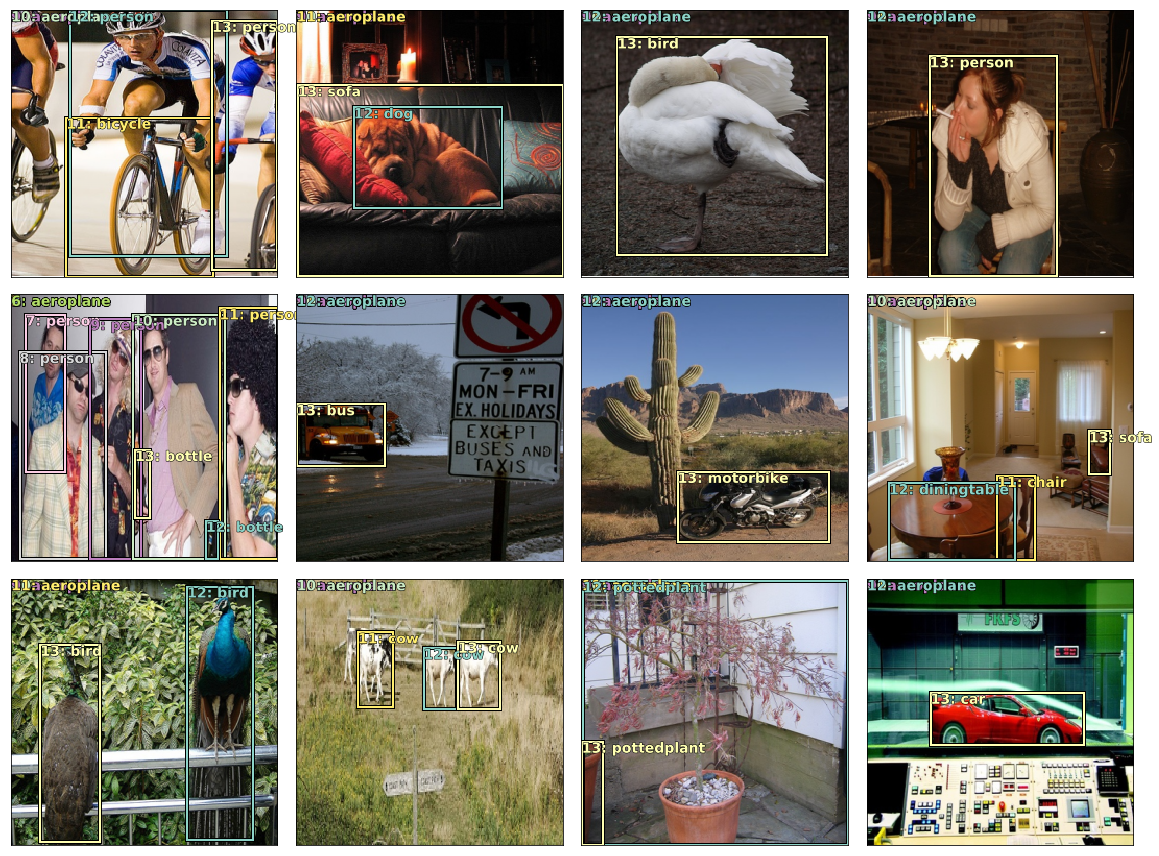

In [28]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [29]:
# check data 
x, y = next(iter(md.trn_dl))

In [30]:
x.size(), y[0].size(), y[1].size()

(torch.Size([64, 3, 256, 256]), torch.Size([64, 40]), torch.Size([64, 10]))

## Model: RetinaNet

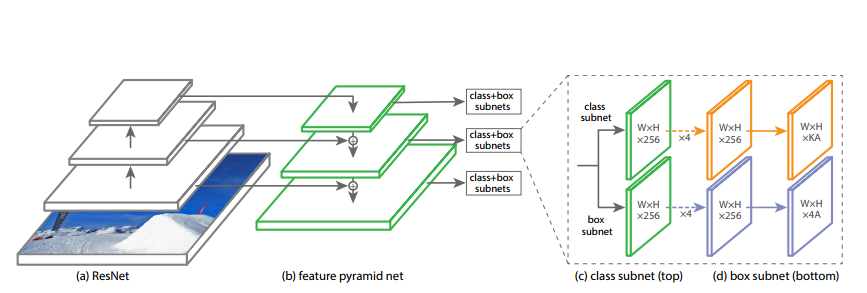

### Subnet1: Classification

"Taking an input feature map with C channels from a given pyramid level, the subnet applies four 3x3 conv layers, 
each with C filters and each followed by ReLU activations, followed by a 3x3 conv layer with KA filters."

We will use same notations from the paper 

**K:** number of classes

**A:** number of anchors

All new conv layers except the final one in the RetinaNet subnets are initialized with bias b = 0
and a Gaussian weight fill with $\sigma = 0.01$. For the final conv layer of the classification subnet, we set the bias initialization to $b = − log((1 − \pi)/\pi)$.

In [27]:
K, A, C = len(id2cat)+1, 1, 256

In [28]:
def conv_bn_relu(kernel_size=3,stride=1, pad=1,in_c=256, out_c=256, use_bn=False):
    block = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size, stride, pad),
        nn.ReLU())
    if use_bn: block.add_module('3', nn.BatchNorm2d(in_c))
    # all new conv layers gaussian with mean = 0 and std = 0.01, bias = 0
    block[0].weight.data.normal_(0, 0.01)
    block[0].bias.data.zero_()
    return block

In [29]:
def flatten_conv(x,A):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//A)

In [30]:
class Subnet1(nn.Module):
    """For classification: outputs K*A"""
    def __init__(self, K, A, in_c, use_bn=False, depth=4, pi=0.01):
        super().__init__()
        self.A = A
        self.conv = nn.Sequential(*[conv_bn_relu(in_c=in_c, use_bn=use_bn) for i in range(depth)]) 
        self.out_conv = nn.Conv2d(in_c, K*A, 3, 1, 1)    
        # set out_conv weight to N(0, 0.01) 
        self.out_conv.weight.data.normal_(0, 0.01)
        # set out conv bias to -np.log((1-pi)/pi)
        self.out_conv.bias.data = self.out_conv.bias.data.zero_() + -np.log((1-pi)/pi)

    def forward(self, x):
        return flatten_conv(self.out_conv(self.conv(x)), self.A)

In [31]:
subnet1 = Subnet1(K, A, C)

In [88]:
subnet1

Subnet1(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
  )
  (out_conv): Conv2d (256, 21, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

### Subnet2: Box Regression

"The design of the box regression subnet is identical to the classification subnet except that it terminates in 4A linear outputs per spatial location."

In [32]:
class Subnet2(nn.Module):
    """For classification: outputs 4*A"""
    def __init__(self, A, in_c, use_bn=False, depth=4):
        super().__init__()
        self.A = A
        self.conv = nn.Sequential(*[conv_bn_relu(in_c=in_c, use_bn=use_bn) for i in range(depth)]) 
        self.out_conv = nn.Conv2d(in_c, 4*A, 3, 1, 1)    
        # set out_conv weight to N(0, 0.01) 
        self.out_conv.weight.data.normal_(0, 0.01)
        # set out conv bias = 0
        self.out_conv.bias.data.zero_()

    def forward(self, x):
        return flatten_conv(self.out_conv(self.conv(x)), self.A)

In [94]:
subnet2 = Subnet2(A, C)

In [95]:
subnet2

Subnet2(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
  )
  (out_conv): Conv2d (256, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

### Test

In [97]:
inp = V(torch.ones(1,256,8,8))

In [98]:
class_out = subnet1(inp)

In [99]:
bbox_out = subnet2(inp)

In [100]:
# total of H*W*A predictions for each anchor
class_out.size(), bbox_out.size()

(torch.Size([1, 64, 21]), torch.Size([1, 64, 4]))

### Backbone (ResNet + FPN)

"We experiment with ResNet-50-FPN and ResNet-101-FPN backbones [20]. The base ResNet-50 and ResNet-101 models are pre-trained on ImageNet1k; we use the models released by [16]. New layers added for FPN are initialized as in [20]."

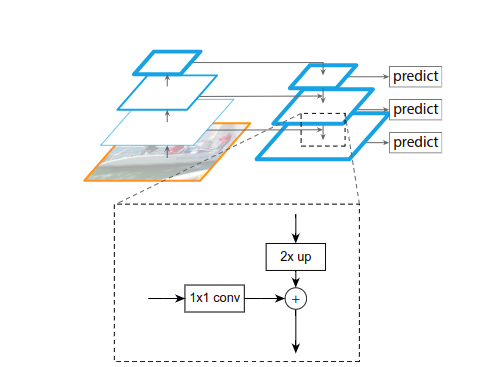

In [33]:
# load defined model
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

In [34]:
class SaveFeatures():
    """ Extract pretrained activations"""
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [113]:
f_model=resnet50
sz=224
bs=64

cut, cut_lr = model_meta[f_model]
inp = V(torch.ones(1,3,sz,sz))
encoder = get_encoder(f_model, cut)

In [117]:
sfs = [SaveFeatures(encoder[i]) for i in range(len(children(encoder)))]

In [118]:
inp = V(torch.ones(1,3,sz,sz))

In [119]:
encoder(inp).size()

torch.Size([1, 2048, 7, 7])

RetinaNet uses feature pyramid levels P3 to P7, where P3 to P5 are computed from the output of the corresponding ResNet residual stage (C3 through C5) using top-down and lateral connections just as in [FPN PAPER],

P6 is obtained via a 3x3 stride-2 conv on C5, and P7 is computed by apply-ing ReLU followed by a 3x3 stride-2 conv on P6. This differs slightly from [20]: (1) we don’t use the high-resolution pyramid level P2 for com-putational reasons, (2) P6 is computed by strided convolution instead of downsampling, and (3) we include P7 to improve large object detection. These minor modifications improve speed while maintaining accuracy. 4

In [124]:
# index C1, C2, C3, C4, C5 -> p2_out, p3_out, p4_out, p5_out, p6_out
[stage_act.features.size() for stage_act in sfs]

[torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 56, 56]),
 torch.Size([1, 256, 56, 56]),
 torch.Size([1, 512, 28, 28]),
 torch.Size([1, 1024, 14, 14]),
 torch.Size([1, 2048, 7, 7])]

In [51]:
class FPN(nn.Module):
    def __init__(self, encoder, out_c=256):
        super().__init__()
        self.encoder = encoder        
        self.sfs = [SaveFeatures(encoder[i]) for i in range(len(children(encoder)))]
        self.out_c = out_c
                
    def forward(self, x):
        #pdb.set_trace()
        # encode image with ResNet backbone
        x = self.encoder(x)
        
        # get c1, c2, c3, c4, c5 activations
        c1 = self.sfs[2].features  #64 (sz/2)
        c2 = self.sfs[4].features  #256 (sz/4)
        c3 = self.sfs[5].features  #512 (sz/8)
        c4 = self.sfs[6].features  #1024 (sz/16)
        c5 = self.sfs[7].features  #2048 (sz/32) : sz should be divisible by 32
        
        C_sz = c5.size()[1] # 2048
        
        # construct convs
        if not hasattr(self, 'P6_conv1'):
            # get channel size of each intermediate activation
            self.sfs_c_sz = [stage_act.features.size()[1] for stage_act in self.sfs]
            
            self.P6_conv1 = nn.Conv2d(C_sz, self.out_c, kernel_size=3, stride=2, padding=1)
            self.P6_conv2 = nn.Conv2d(self.out_c, self.out_c, kernel_size=3, stride=1, padding=1)
            
            self.P5_conv1 = nn.Conv2d(C_sz, self.out_c, kernel_size=1, stride=1, padding=0)
            self.P5_conv2 = nn.Conv2d(self.out_c, self.out_c, kernel_size=3, stride=1, padding=1)
            
            self.P4_conv1 = nn.Conv2d(C_sz//2, self.out_c, kernel_size=1, stride=1, padding=0)
            self.P4_conv2 = nn.Conv2d(self.out_c, self.out_c, kernel_size=3, stride=1, padding=1)
            
            self.P3_conv1 = nn.Conv2d(C_sz//4, self.out_c, kernel_size=1, stride=1, padding=0)
            self.P3_conv2 = nn.Conv2d(self.out_c, self.out_c, kernel_size=3, stride=1, padding=1)
            
            self.P2_conv1 = nn.Conv2d(C_sz//8, self.out_c, kernel_size=1, stride=1, padding=0)
            self.P2_conv2 = nn.Conv2d(self.out_c, self.out_c, kernel_size=3, stride=1, padding=1)        
            
        # get P2, P3, P4, P5, P6
        p6 = self.P6_conv1(c5)
        p6_out = self.P6_conv2(p6)
        
        p5 = self.P5_conv1(c5) + F.upsample(p6, scale_factor=2, mode='nearest')
        p5_out = self.P5_conv2(p5)
        
        p4 = self.P4_conv1(c4) + F.upsample(p5, scale_factor=2, mode='nearest')
        p4_out = self.P4_conv2(p4)
        
        p3 = self.P3_conv1(c3) + F.upsample(p4, scale_factor=2, mode='nearest')
        p3_out = self.P3_conv2(p3)
        
        p2 = self.P2_conv1(c2) + F.upsample(p3, scale_factor=2, mode='nearest')
        p2_out = self.P2_conv2(p2)
    
        return [p2_out, p3_out, p4_out, p5_out, p6_out]

In [229]:
f_model=resnet34
sz=256
bs=64

cut, cut_lr = model_meta[f_model]
inp = V(torch.ones(1,3,sz,sz))
encoder = get_encoder(f_model, cut)

In [230]:
out = encoder(inp)

In [231]:
fpn = FPN(encoder=encoder)

In [232]:
outs = fpn(inp)

In [233]:
[out.size() for out in outs]

[torch.Size([1, 256, 64, 64]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 256, 16, 16]),
 torch.Size([1, 256, 8, 8]),
 torch.Size([1, 256, 4, 4])]

### RetinaNet

In [36]:
class RetinaNet(nn.Module):
    def __init__(self, fpn, subnet1, subnet2):
        super().__init__()
        self.fpn = fpn
        self.subnet1 = subnet1
        self.subnet2 = subnet2
    
    def forward(self, x):
        p2_out, p3_out, p4_out, p5_out, p6_out = self.fpn(x)
        
        cls_out1 = self.subnet1(p2_out) # 4x4 - > 16*A anchors
        cls_out2 = self.subnet1(p3_out) # 8x8 - > 64*A anchors
        cls_out3 = self.subnet1(p4_out) # 16x16 - > 256*A anchors
        cls_out4 = self.subnet1(p5_out) # 32x32 - > 32*32*A anchors
        cls_out5 = self.subnet1(p6_out) # 64x64 - > 64*64*A anchors
        
        reg_out1 = self.subnet2(p2_out) # 4x4 - > 16*A anchors
        reg_out2 = self.subnet2(p3_out) # 8x8 - > 64*A anchors
        reg_out3 = self.subnet2(p4_out) # 16x16 - > 256*A anchors
        reg_out4 = self.subnet2(p5_out) # 32x32 - > 32*32*A anchors
        reg_out5 = self.subnet2(p6_out) # 64x64 - > 64*64*A anchors
        
        return [torch.cat([cls_out1, cls_out2, cls_out3, cls_out4, cls_out5], 1),
               torch.cat([reg_out1, reg_out2, reg_out3, reg_out4, reg_out5], 1)]

In [244]:
# 20 classes, 9 anchors per grid and 256 channels
K, A, in_c = len(id2cat), 9, 256

In [245]:
# initialize retinanet model
fpn, subnet1, subnet2 = FPN(encoder), Subnet1(K, A, in_c), Subnet2(A, in_c)
retina = RetinaNet(fpn, subnet1, subnet2)

In [246]:
out = retina(inp)

In [247]:
out[0].size(), out[1].size()

(torch.Size([1, 49104, 20]), torch.Size([1, 49104, 4]))

### Creating Anchors for Model

We constructed the model to output from different levels of FPN. These feature maps will have sizes 4x4, 8x8 and 16x16 respectively. 

In [1]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

anc_grids = [4, 8, 16, 32, 64] 
             
anc_zooms = [1, 2**(1/3), 2**(2/3)]
#anc_zooms = [1]
anc_ratios = [(1.,2.), (1.,1), (2.,1.)]
#anc_ratios = [(1., 1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios] # n_anc_zooms * n_anc_ratios

k = len(anchor_scales)

anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [2]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

NameError: name 'np' is not defined

In [3]:
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

NameError: name 'np' is not defined

In [40]:
anchor_cnr

Variable containing:
 0.0000  0.0000  0.2500  0.2500
 0.0000  0.0625  0.2500  0.1875
 0.0625  0.0000  0.1875  0.2500
               ⋮                
 0.9789  0.9789  1.0055  1.0055
 0.9789  0.9855  1.0055  0.9988
 0.9855  0.9789  0.9988  1.0055
[torch.FloatTensor of size 49104x4]

### Loss and Model Definition

In [41]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(len(id2cat))

In [42]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [43]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    bs = targ[0].size()[0]
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return (lls+lcs) / bs

In [44]:
# wrap for fastai 
class RetinaNetModel():
    def __init__(self, model, cut_lr, name='retinanet'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.fpn.encoder), [self.cut_lr]))
        return lgs + children(self.model.fpn)[1:] + [children(self.model.subnet1)] + [children(self.model.subnet2)]

### Training

In [52]:
f_model=resnet34
sz=256
bs=64

cut, cut_lr = model_meta[f_model]
inp = V(torch.ones(1,3,sz,sz))
encoder = get_encoder(f_model, cut)

In [53]:
# initialize retinanet model
in_c = 256
fpn, subnet1, subnet2 = FPN(encoder), Subnet1(K, A, in_c), Subnet2(A, in_c)
retina = RetinaNet(fpn, subnet1, subnet2)
model = RetinaNetModel(retina, 8)

In [54]:
# init learner and define optimizer 
learn = ConvLearner(md, model)
learn.crit = ssd_loss
learn.opt_fn = optim.Adam

In [55]:
learn.freeze_to(1)

In [56]:
learn.lr_find(start_lr=.1, end_lr=30)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/32 [00:00<?, ?it/s]


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/kerem/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/kerem/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/kerem/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at /opt/conda/conda-bld/pytorch_1512387374934/work/torch/lib/TH/THGeneral.c:246